# Backpropagation from scratch

Original Source is: [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0?si=ooLtYbzFeESjd3Li) by Andrej Karpathy.

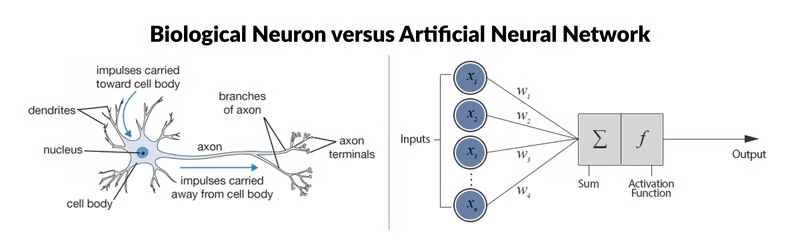

## Set up environment

In [1]:
import numpy as np
np.random.seed = 42

import pandas as pd
from pandas import DataFrame

from typing import List, Callable

from matplotlib import pyplot as plt

from graphviz import Digraph

## Hyperparams

In [2]:
TEST_SIZE = 0.1

LEARNING_RATE = 0.01
BATCH_SIZE = 1
EPOCHS = 500

HIDDEN_LAYERS_NUM = 1
HIDDEN_NEURONS_NUM = 4
OUTPUT_NEURONS_NUM = 1

## Utilities

In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Load data

In [4]:
df = pd.read_csv("ice_cream_data.csv", sep=",")
df = df.sample(frac=1)
df.head()

,Temperature,Is_Weekend,Ice_Creams_Sold
346,29.052810,0,251
64,18.428035,0,144
311,12.353691,0,123
236,18.423171,1,213
106,22.311488,0,171


### Separate input from target

In [5]:
targets = df["Ice_Creams_Sold"]
inputs = df.drop(["Ice_Creams_Sold"], axis=1)

In [6]:
inputs.min()

Temperature    10.151848
Is_Weekend      0.000000
dtype: float64

In [7]:
inputs.max()

Temperature    39.99153
Is_Weekend      1.00000
dtype: float64

### Normalize input

In [8]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [9]:
norm_inputs = normalize_input(inputs)

In [10]:
norm_inputs.min()

Temperature    0.0
Is_Weekend     0.0
dtype: float64

In [11]:
norm_inputs.max()

Temperature    1.0
Is_Weekend     1.0
dtype: float64

### Numpy

In [12]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.63341699, 0.        ],
       [0.27735509, 0.        ],
       [0.07378912, 0.        ],
       [0.27719207, 1.        ],
       [0.40749898, 0.        ]])

In [13]:
inputs.shape

(600, 2)

In [14]:
targets = targets.to_numpy()
targets[:5]

array([251, 144, 123, 213, 171])

### Train vs. Test set

In [15]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 540, Test size: 60


## Train Model

### Model

In [16]:
class Variable:
    def __init__(self, label = "", data = 0.0, _children = (), _op = "", trainable = False):
        self.label = label
        self._forward = None
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._trainable = trainable

        self._prev = set(_children)
        self._op = _op

    def __str__(self):
        return f"{self.label}:{self.data}"

    def __add__(self, other):
        result = Variable(_children=(self, other), _op="+")

        def forward():
            return self.forward() + other.forward()
        result._forward = forward

        def backward():
            self.grad = 1.0 * result.grad
            other.grad = 1.0 * result.grad
        result._backward = backward
        
        return result

    def __mul__(self, other):
        result = Variable(_children=(self, other), _op="*")

        def forward():
            return self.forward() * other.forward()
        result._forward = forward
        
        def backward():
            self.grad = other.data * result.grad
            other.grad = self.data * result.grad
        result._backward = backward

        return result
    
    def tanh(self):
        result = Variable(_children=(self,), _op="tanh")

        def forward():
            return np.tanh(self.forward())
        result._forward = forward
        
        def backward():
            self.grad = (1 - np.tanh(self.data) ** 2) * result.grad
        result._backward = backward

        return result
    
    def mse(self, target):
        result = Variable(_children=(self, target), _op="mse")

        def forward():
            return (target.forward() - self.forward()) ** 2
        result._forward = forward

        def backward():
            self.grad = 2 * (self.data - target.data)
            target.grad = 2 * (target.data - self.data)
        result._backward = backward

        return result

    def forward(self):
        if self._forward:
            self.data = self._forward()
        return self.data

    def backward(self):
        # Base case
        self.grad = 1.0
        self._backward()

        nodes = list(self._prev)
        while nodes:
            node = nodes.pop()
            nodes.extend(list(node._prev))
            node._backward()
            if (node._trainable):
                node.data = node.data - node.grad * LEARNING_RATE

In [17]:
input1 = Variable("input1")
input2 = Variable("input2")
target = Variable("target")

weight1 = Variable(label="weight1", data=np.random.uniform(-0.1, 0.1), trainable=True)
weight2 = Variable(label="weight2", data=np.random.uniform(-0.1, 0.1), trainable=True)
bias = Variable(label="bias", data=0.01, trainable=True)

weighted_input1 = input1 * weight1
weighted_input1.label = "weighted_input1"
weighted_input2 = input2 * weight2
weighted_input2.label = "weighted_input2"
weighted_input_sum = weighted_input1 + weighted_input2
weighted_input_sum.label = "weighted_input_sum"
sum = weighted_input_sum + bias
sum.label = "sum"
output = sum
# TODO: add classification case
# output = sum.tanh()
output.label = "output"
loss = output.mse(target)
loss.label = "loss"

### Training

In [18]:
data_size = len(inputs_train)

history = []
for epoch in range(EPOCHS):
    losses = []
    for batch_index in range(data_size // BATCH_SIZE):
        input1.data = inputs_train[batch_index][0]
        input2.data = inputs_train[batch_index][1]
        target.data = targets_train[batch_index]

        loss_value = loss.forward()
        losses.append(loss_value)

        loss.backward()

    # History for learning curve
    average_loss = np.array(losses).sum() / len(losses)
    history.append(average_loss)
    print(f"Epoch {epoch}: loss={average_loss}")

    # Early Stopping
    patience = 10
    delta = 1
    if len(history) >= patience and all(abs(history[-i] - history[-i-1]) <= delta for i in range(1, patience)):
        break


Epoch 0: loss=3037.4561980968256
Epoch 1: loss=469.20047936140753
Epoch 2: loss=281.48922233491754
Epoch 3: loss=240.50123459985517
Epoch 4: loss=231.52060449233434
Epoch 5: loss=229.54207256871217
Epoch 6: loss=229.1011110775356
Epoch 7: loss=229.00049335688635
Epoch 8: loss=228.97646730664482
Epoch 9: loss=228.97025420102992
Epoch 10: loss=228.9684445367068
Epoch 11: loss=228.96783752684559
Epoch 12: loss=228.96760598000688
Epoch 13: loss=228.96750917331917
Epoch 14: loss=228.96746643538265


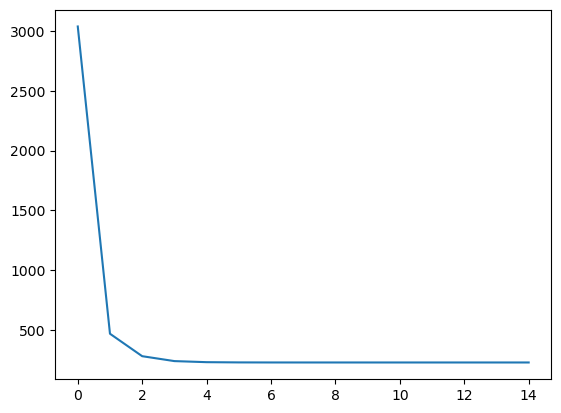

In [19]:
plt.plot(history)

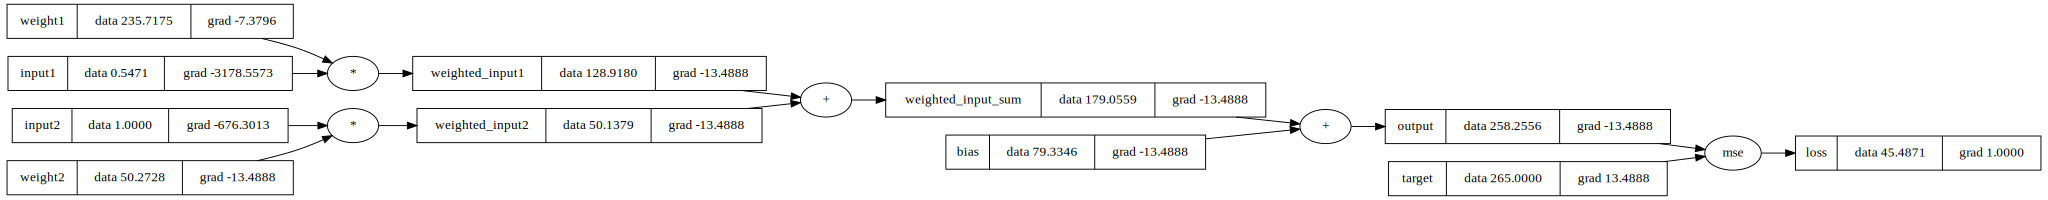

In [20]:
draw_dot(loss)

## Test solution

In [21]:
losses = []
for index in range(len(inputs_test)):
    input1.data = inputs_test[index][0]
    input2.data = inputs_test[index][1]
    target.data = targets_test[index]
    loss_value = loss.forward()
    losses.append(loss_value)

In [22]:
losses

[6.114898298704537,
 389.14897813913876,
 0.10029528165063514,
 455.13863601662626,
 31.689978570788227,
 412.76407137576876,
 62.4912278425328,
 412.8119464640036,
 384.9938340310789,
 341.65973607836986,
 3.3019618191982123,
 1391.6608033092969,
 41.640230538832114,
 508.78526158810524,
 71.77815774402227,
 50.901449263408374,
 516.8813390141532,
 746.8979107868225,
 88.46268049506303,
 64.6907906962444,
 83.84446752122602,
 1272.7951301579255,
 646.3181911427073,
 1104.1626725731417,
 23.36684188915737,
 49.707396459846336,
 31.127119699986963,
 572.5566503457377,
 2.173614967617781,
 657.2362877955998,
 699.0721782041428,
 13.448822618511493,
 7.880784926563772,
 57.38547569888118,
 9.2648970121892,
 301.9366023640206,
 852.5009237561686,
 32.06955369024593,
 125.94709424534192,
 135.72605750151007,
 121.34354528582644,
 55.122792182767576,
 363.1952191320631,
 156.59771216865678,
 933.6606696452831,
 0.1303603532480539,
 7.004533648144864,
 235.53596546941444,
 1.8732308493813141,

In [23]:
average_loss = np.array(losses).sum() // len(losses)

In [24]:
rmse = np.sqrt(np.mean(losses))
mean_target = np.mean(targets)
print("RMSE:", rmse)
print("Mean of targets:", mean_target)

RMSE: 16.856614377038266
Mean of targets: 216.425
